<a href="https://colab.research.google.com/github/lysvallee/lysvallee.github.io/blob/gh-pages/FAO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importer librairies
import numpy as np
import pandas as pd
import sqlite3
from glob import glob
from os import chdir, path
import matplotlib.pyplot as plt
import plotly.express as px

In [ ]:
# mount GoogleDrive and set the files path
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks


In [ ]:
chdir('/content/drive/MyDrive/DATA IA Projet 1/')
fns = glob('FAOSTAT_2013_*.csv')
fns

['FAOSTAT_2013_population.csv',
 'FAOSTAT_2013_animal.csv',
 'FAOSTAT_2013_cereal.csv',
 'FAOSTAT_2013_vegetal.csv',
 'FAOSTAT_2013_sous_alimentation.csv']

In [ ]:
# Ouverture sqllite
conn = sqlite3.connect('bdd.sqlite')

In [ ]:
# Noms de colonnes à utiliser
names = ['Code Domaine', 'Domaine', 'Code Pays', 'Pays', 'Code Élément',
         'Élément', 'Code Produit', 'Produit', 'Code Année', 'Année', 'Unité',
         'Valeur', 'Symbole', 'Description du Symbole']

In [ ]:
# Lecture puis affichage des info taille des CSV, puis création des bdd
for fn in fns:
    fnshort = path.splitext(fn)[0]
    fnshort = fnshort.split('2013_')[1]
    df = pd.read_csv(fn, names=names, header=0)
    print(f"- {fn:50s} ({df.shape[0]:6d}, {df.shape[1]:2d})")
    df.to_sql(fnshort, con=conn, if_exists='replace')


- FAOSTAT_2013_population.csv                        (   175, 14)
- FAOSTAT_2013_animal.csv                            ( 37166, 14)


/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:2872: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


- FAOSTAT_2013_cereal.csv                            ( 16057, 14)
- FAOSTAT_2013_vegetal.csv                           (104871, 14)
- FAOSTAT_2013_sous_alimentation.csv                 (   204, 14)


In [ ]:
# création d'un dataframe à partir de la bdd
SQL = '''
SELECT population."Code Pays", population.Pays, population.Valeur AS population, cereal.Valeur AS cereal
FROM population 
INNER JOIN cereal
ON (population."Code Pays" = cereal."Code Pays")
WHERE cereal.Élément="Production" AND cereal.Produit="Blé"
    AND cereal.Valeur>0
ORDER BY population."Code Pays"
; 
'''

df = pd.read_sql(SQL, conn)
df

,Code Pays,Pays,population,cereal
0,1,Armenia,2977,312.0
1,2,Afghanistan,30552,5169.0
2,3,Albania,3173,294.0
3,4,Algeria,39208,3299.0
4,7,Angola,21472,4.0
...,...,...,...,...
107,256,Luxembourg,530,91.0
108,272,Serbia,9511,2690.0
109,273,Montenegro,621,2.0
110,276,Sudan,37964,265.0


In [ ]:
#ajout des infos surface et continent dans le df
glob('*add.csv')

['FAOSTAT_continents_add.csv', 'FAOSTAT_area_add.csv']

In [ ]:
# rajouter les continents 
continents = pd.read_csv('FAOSTAT_continents_add.csv')
continents = continents[['name', 'region','sub-region']]
continents.head()

,name,region,sub-region
0,Afghanistan,Asia,Southern Asia
1,Åland Islands,Europe,Northern Europe
2,Albania,Europe,Southern Europe
3,Algeria,Africa,Northern Africa
4,American Samoa,Oceania,Polynesia


In [ ]:
df_continents = pd.merge(df, continents, how='inner', left_on='Pays', right_on='name')
df_continents.rename(columns = {'region': 'continent', 'sub-region' : 'sous-continent'}, inplace=True)
del df_continents["name"]
df_continents.head()

,Code Pays,Pays,population,cereal,continent,sous-continent
0,1,Armenia,2977,312.0,Asia,Western Asia
1,2,Afghanistan,30552,5169.0,Asia,Southern Asia
2,3,Albania,3173,294.0,Europe,Southern Europe
3,4,Algeria,39208,3299.0,Africa,Northern Africa
4,7,Angola,21472,4.0,Africa,Sub-Saharan Africa


In [ ]:
df_continents.shape

(104, 6)

**Graphes**

Scatterplot production blé selon population

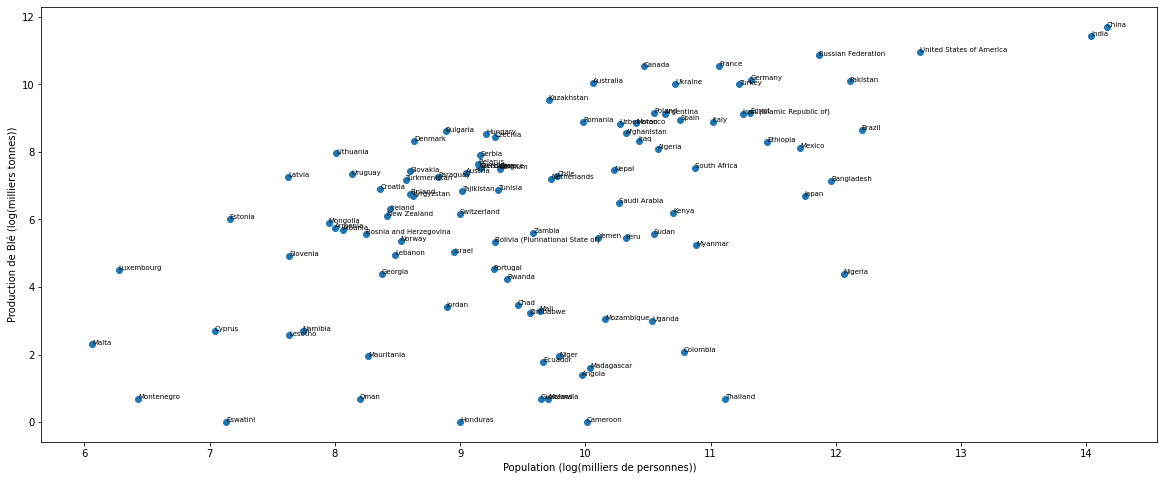

In [ ]:
# 1ere version: avec matplotlib
x = np.log(df_continents['population'])
y = np.log(df_continents['cereal'])

plt.figure(figsize=(20, 8))
plt.scatter(x, y) # le graph

plt.xlabel("Population (log(milliers de personnes))") # label axe x
plt.ylabel("Production de Blé (log(milliers tonnes))") #label axe y

# Ajout des labels pour chaque ligne (coordonnées en LOG)
for i,x in df_continents.iterrows():
    plt.annotate(x['Pays'],
                 (np.log(x['population']), np.log(x['cereal'])),
                 fontsize=7)

# Affichage
plt.show()


In [ ]:
# 2eme version: interactif avec plotly 
# a compléter

Pareto population

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29],
 <a list of 30 Text major ticklabel objects>)

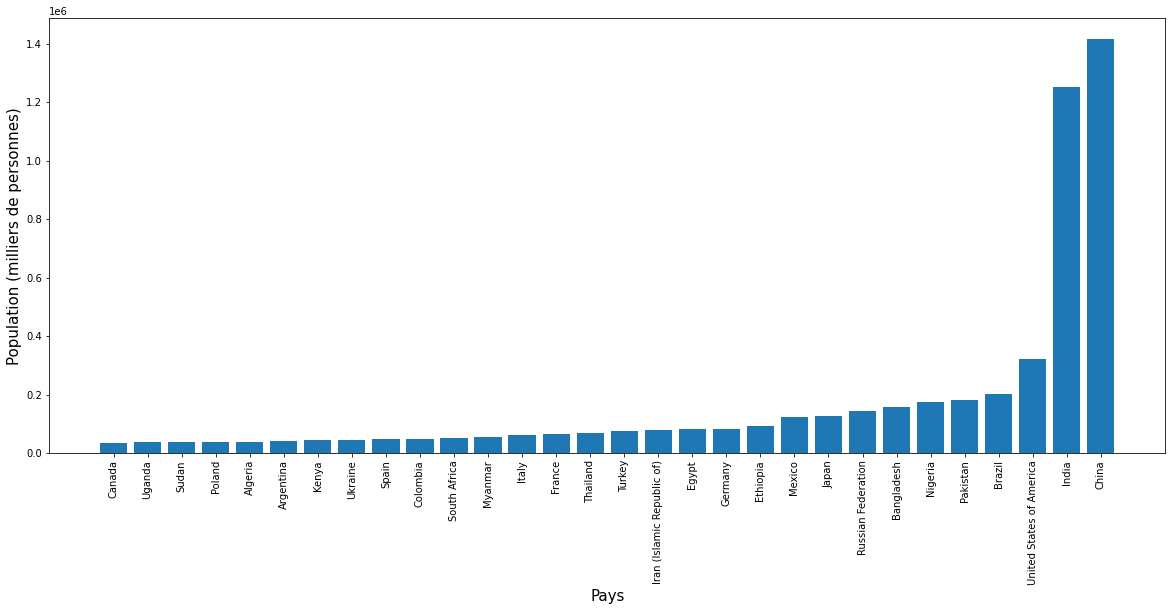

In [ ]:
# A supprimer plsu tard, ici intermédiare avant de faire le pareto
# barplot pour population, 30 pays les plus peuplés

plt.figure(figsize=(20, 8))
plt.bar('Pays', 'population',data=df_continents.sort_values('population')[-30:])
plt.xlabel("Pays", size=15)
plt.ylabel("Population (milliers de personnes)", size=15)
plt.xticks(rotation='vertical')
# voir si on peut changer l'affichage des axes des ordonnes pour mettre en forme 10⁶



In [ ]:
# associer une couleur à un continent

print(df_continents.continent.unique())

# dictionnaire continent-couleur
# Tableau palette https://matplotlib.org/stable/gallery/color/named_colors.html
color_code = { 
'Asia' : 'tab:blue',
'Americas' : 'tab:orange',
'Africa' : 'tab:green',
'Europe' : 'tab:red',
'Oceania' : 'tab:purple'
}

# fonction associe continent à couleur 
def associate_color(x):
  col = color_code.get(x)
  return(col)

# nouvelle colonne contenant couleur
df_continents['couleur'] = df_continents['continent'].apply(associate_color)

df_continents.shape # 103 lignes


['Asia' 'Europe' 'Africa' 'Americas' 'Oceania']


(104, 7)

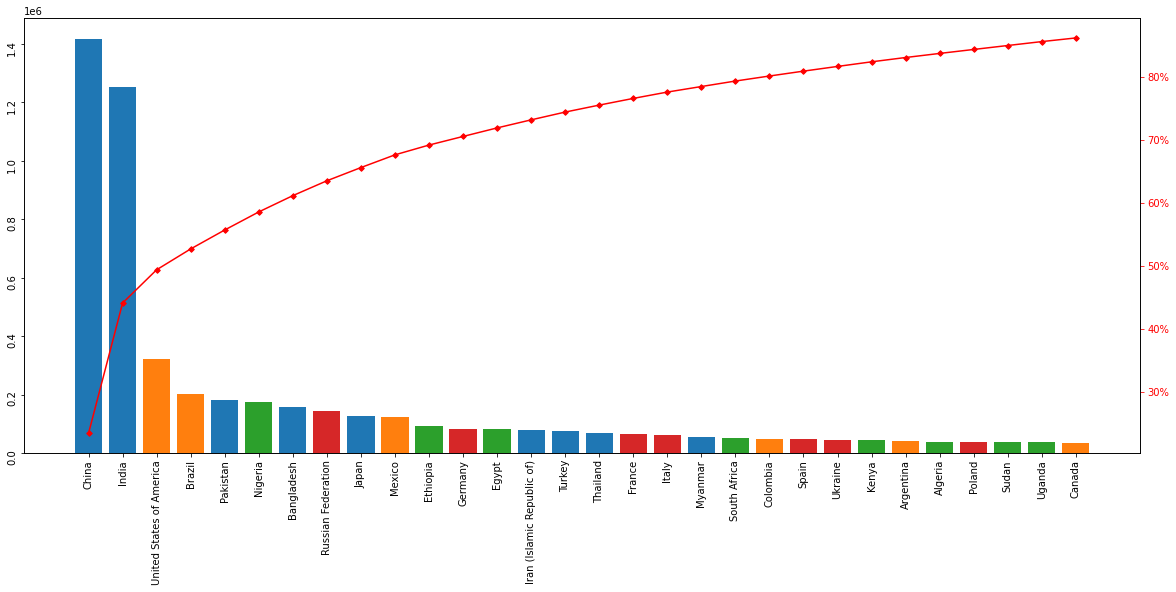

In [ ]:
df_continents_sort = df_continents.sort_values(by='population', ascending=False)

from matplotlib.ticker import PercentFormatter # a envoyer en haut du collab si on garde cette solution

# créer colonne avec pourcentage cumulé
df_continents_sort['cumperc'] = df_continents_sort['population'].cumsum()/df_continents_sort['population'].sum()*100

# créer barplot
fig, ax = plt.subplots(figsize=(20,8))
ax.bar('Pays', 'population',data=df_continents_sort[:30], color=df_continents_sort['couleur'])

# plot pourcentage cumulé
ax2 = ax.twinx()
ax2.plot('Pays', 'cumperc', color="red", marker="D", ms=4, data= df_continents_sort[:30])
ax2.yaxis.set_major_formatter(PercentFormatter())

#changer couleurs axes
ax2.tick_params(axis='y', colors="red")

# faire tourner labels
ax.tick_params(labelrotation=90)



In [ ]:
import matplotlib.colors as pltcol
couleursmap = pltcol.Colormap('viridis',5)
print(couleursmap)


cmap = pltcol.get_cmap('Spectral')

rgba = cmap(0.5)
print(rgba)

AttributeError: ignored

**Pareto malnutrition**

In [ ]:
# on refait le df en ajoutant malnutrition en tant que colonne
# on aurait pu le faire au debut au moment ou on crée le df pour la première fois? a voir si possible d'homogénéiser
df_mal = pd.read_sql_query("""SELECT population."Code Pays", population."Pays", 
                       population.Valeur AS Population, cereal.Valeur AS Cereale,
                       sous_alimentation.Valeur AS malnutrition
FROM population
INNER JOIN cereal
ON (population."Code Pays" = cereal."Code Pays")
INNER JOIN sous_alimentation
ON (population."Code Pays" = sous_alimentation."Code Pays")
WHERE (cereal."Élément" = "Production" AND cereal."Produit" = "Blé" AND cereal.Valeur > 0)
ORDER BY population."Code Pays" ;""",
con =conn)

print(df_mal.shape)
print(df_mal.head())

In [ ]:
df_mal_sort = df_mal.sort_values(by='malnutrition', ascending=False)

# créer colonne avec pourcentage cumulé
df_mal_sort['cumperc_mal'] = df_mal_sort['malnutrition'].cumsum()/df_mal_sort['malnutrition'].sum()*100

# créer barplot
fig, ax = plt.subplots(figsize=(20,8))
ax.bar('Pays', 'malnutrition',data=df_mal_sort[:30], color="blue")

# dupliquer barplot, plot pourcentage cumulé
ax2 = ax.twinx()
ax2.plot('Pays', 'cumperc_mal', color="red", marker="D", ms=4, data= df_mal_sort[:30])
ax2.yaxis.set_major_formatter(PercentFormatter())

#changer couleurs axes
ax.tick_params(axis='y', colors="blue")
ax2.tick_params(axis='y', colors="red")

# faire tourner labels
ax.tick_params(labelrotation=90)


Densité

In [ ]:
# Inclusion de la surface dans le data frame
area = pd.read_csv('FAOSTAT_area_add.csv')
area = df_area[['Code zone (FAO)', 'Valeur']]
area.head()

In [ ]:
# nouveau df avec surface, en se basant sur le code pays/ code zone
df_area = pd.merge(df, area, how='inner', left_on='Code Pays', right_on='Code zone (FAO)')
df_area.rename(columns = {'Valeur': 'Surface'}, inplace=True)
del df_area["Code zone (FAO)"]
df_area.head()